In [183]:
require 'cudnn'
require 'inn'
require 'image'
require 'dcnn'
Plot = require 'itorch.Plot'

-- Loads the mapping from net outputs to human readable labels
function load_synset()
  local file = io.open 'synset_words.txt'
  local list = {}
  while true do
    local line = file:read()
    if not line then break end
    table.insert(list, string.sub(line,11))
  end
  return list
end

-- Converts an image from RGB to BGR format and subtracts mean
function preprocess(im, img_mean)
  -- rescale the image
  local im3 = image.scale(im,224,224,'bilinear')*255
  -- RGB2BGR
  local im4 = im3:clone()
  im4[{1,{},{}}] = im3[{3,{},{}}]
  im4[{3,{},{}}] = im3[{1,{},{}}]

  -- subtract imagenet mean
  return im4 - image.scale(img_mean, 224, 224, 'bilinear')
end

-- Lua implementation of PHP scandir function
function scandir(directory)
    local i, t, popen = 0, {}, io.popen
    for filename in popen('ls -a "'..directory..'"'):lines() do
        if filename:match "%.JPEG$" then
            i = i + 1
            t[i] = filename

        end
    end
    return t, i
end


--fileDir = './test_n01443537'
fileDir = './n01443537'
fileList, total_files = scandir( fileDir )
true_label = 2



-- Setting up networks 
print '==> Loading network'

--net = torch.load('/home/yusheng/Workspace/DeepLearning/models/zeilerNet/zeilerNet.net')
net = torch.load('/usr/local/data/zeilerNet/zeilerNet.net')
--net:add(nn.Sigmoid())
net:cuda()
-- as we want to classify, let's disable dropouts by enabling evaluation mode
net:evaluate()


print '==> Loading synsets'
synset_words = load_synset()

print '==> Loading image and imagenet mean'
image_name = 'Goldfish3.jpg'
--image_name = 'lena.jpg'
--image_name='people2.jpg'
img_mean_name = 'ilsvrc_2012_mean.t7'

im = image.load(image_name)
img_mean = torch.load(img_mean_name).img_mean:transpose(3,1)

==> Loading network	


==> Loading synsets	


==> Loading image and imagenet mean	


In [184]:
function Find_diff_by_drop1( output_org )
    local topN_index = {}
    local n = 256
    for i=1, n do
        topN_index[i] = { idx=0, diff=nil }
    end

    for i=1, net:get(1):get(13).output:size(1) do
        local incomplete_fm = net:get(1):get(13).output:clone()
        incomplete_fm[i]:zero()
        local label_prob = {}
        label_prob = classifier:forward(incomplete_fm):view(-1):float()
        --local diff = output_org - NormalizedMax( sorted_prob )
        local diff = output_org - label_prob[true_label]
        --print( i.. '  '..diff )

        if topN_index[n].diff == nil then 
            topN_index[n].diff = diff
            topN_index[n].idx = i

            local idx = n-1
            while idx>=1 and topN_index[idx].diff == nil do
                topN_index[idx].diff = topN_index[idx+1].diff
                topN_index[idx].idx = topN_index[idx+1].idx
                topN_index[idx+1].diff = nil
                idx = idx - 1
            end
        
            if i==256 then
                for j=1,n-1 do 
                    for k=n,j+1,-1 do
                        -- print(k ..' '.. j )
                        if topN_index[k].diff > topN_index[k-1].diff then  
                            temp_diff = topN_index[k].diff
                            temp_idx = topN_index[k].idx
                            topN_index[k].diff = topN_index[k-1].diff
                            topN_index[k].idx = topN_index[k-1].idx
                            topN_index[k-1].diff = temp_diff
                            topN_index[k-1].idx = temp_idx
                        end
                    end
                end
            end
        else
            local temp_diff = nil
            local temp_idx = 0
            if n>1 then
                for j=1,n-1 do 
                    for k=n,j+1,-1 do
                        -- print(k ..' '.. j )
                        if topN_index[k].diff > topN_index[k-1].diff then  
                            temp_diff = topN_index[k].diff
                            temp_idx = topN_index[k].idx
                            topN_index[k].diff = topN_index[k-1].diff
                            topN_index[k].idx = topN_index[k-1].idx
                            topN_index[k-1].diff = temp_diff
                            topN_index[k-1].idx = temp_idx
                        end
                    end
                end
            end

            if topN_index[n].diff < diff then
                topN_index[n].diff = diff
                topN_index[n].idx = i
            end
        end
    end
--     for i=1,n do
--         print( 'Top'.. i ..' drop down : ' .. topN_index[i].idx .. ' Diff: ' .. topN_index[i].diff) 
--     end
    return topN_index
end

In [185]:
function Insertion( topN_index )
    local classification_curve = torch.Tensor(256)
    
    for top_n=1, 256 do
        local incomplete_fm = net:get(1):get(13).output:clone()
        for i=1,net:get(1):get(13).output:size(1) do
            local drop = true
            for j=1,top_n do
                if i == topN_index[j].idx then
                    drop = false
                end  
            end

            if drop == true then
                --print(i)
                incomplete_fm[i]:zero()
            end
        end

        local sorted_prob = {}
        local classess = {}
        sorted_prob, classes = classifier:forward(incomplete_fm):view(-1):float():sort(true)
        --output_org, average = NormalizedMax( sorted_prob )
        --local ratio_of_mean_error = (output_org - average)/average

--         for i=1,3 do
--             print('Top '..tostring(top_n)..' feature map classification: ', synset_words[classes[i]] .. ' ' .. sorted_prob[i] )
--         end
        
        --print(classes[1])
        if true_label == classes[1] then
            classification_curve[top_n]= sorted_prob[1] 
        else
            classification_curve[top_n] = 0
        end
    end
    
    return classification_curve
end

In [186]:
function Dropout( topN_index )
    local classification_curve = torch.Tensor(256)
    
    for top_n=1, 256 do
        local incomplete_fm = net:get(1):get(13).output:clone()
        for i=1,net:get(1):get(13).output:size(1) do
            local drop = false
            for j=1,top_n do
                if i == topN_index[j].idx then
                    drop = true
                end  
            end

            if drop == true then
                --print(i)
                --print('Drop neuron :'.. i)
                incomplete_fm[i]:zero()
            end
        end

        local sorted_prob = {}
        local classess = {}
        sorted_prob, classes = classifier:forward(incomplete_fm):view(-1):float():sort(true)
        --output_org, average = NormalizedMax( sorted_prob )
        --local ratio_of_mean_error = (output_org - average)/average

        --print('Top '..tostring(top_n)..' feature map classification: ', synset_words[classes[1]] .. ' ' .. sorted_prob[1] )

        --print(classes[1])
        if true_label == classes[1] then
            classification_curve[top_n]= sorted_prob[1] 
        else
            classification_curve[top_n] = 0
        end
    end
    
    return classification_curve
end

In [187]:
print '==> Preprocessing'
--print(fileList)
classifier = nn.Sequential()
classifier:add(net:get(2))
classifier:add(net:get(3))

point_index = torch.Tensor(256)
for i=1, 256 do
    point_index[i] = i
end

local specific_object_statistic = {}
for i=1, total_files do
    specific_object_statistic[i] = { file_name='nil', insertion_curve={}, dropout_curve={}, topN_index={}  }
end

timer = torch.Timer()
--for i=21, 21 do
for i=1, total_files do
    im = image.load( fileDir..'/'..fileList[i] )
    I = preprocess(im, img_mean)

    sorted_prob, classes = net:forward(I:cuda()):view(-1):float():sort(true)
    label_prob = net:forward(I:cuda()):view(-1):float()
    print('Top '..tostring(top_n)..' feature map classification: ', synset_words[classes[1]] .. ' ' .. sorted_prob[1] )
    print( label_prob[true_label] )
    
    print( i..' is finished')
    local topN_index = Find_diff_by_drop1( label_prob[true_label] )
    --print(topN_index )
    local insertion_curve = Insertion( topN_index )
    local dropout_curve = Dropout( topN_index )
    
    specific_object_statistic[i].file_name = fileList[i]
    specific_object_statistic[i].insertion_curve = insertion_curve
    specific_object_statistic[i].dropout_curve = dropout_curve
    specific_object_statistic[i].topN_index = topN_index
    --plot = Plot():line( point_index, insertion_curve,'red','Classification Curve'):legend(true):title('Insertion'):draw()
    --plot = Plot():line( point_index, dropout_curve,'red','Classification Curve'):legend(true):title('Dropout'):draw() 
end

torch.save('n01443537.t7', specific_object_statistic )
print('==> Time elapsed: ' .. timer:time().real .. ' seconds')

==> Preprocessing	


Top nil feature map classification: 	goldfish, Carassius auratus 14.475586891174	
14.475586891174	
1 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.032028198242	


25.032028198242	
2 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.869455337524	
12.869455337524	
3 is finished	


Top nil feature map classification: 	starfish, sea star 9.9497489929199	
8.3770742416382	
4 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.751955032349	
15.751955032349	
5 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.057186126709	
13.057186126709	
6 is finished	


Top nil feature map classification: 	anemone fish 10.443514823914	
8.8476638793945	
7 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.911069869995	
10.911069869995	
8 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.51904296875	
25.51904296875	
9 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.321776390076	
14.321776390076	
10 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.063273429871	
15.063273429871	
11 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.541299819946	
10.541299819946	
12 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.837626457214	
10.837626457214	
13 is finished	


Top nil feature map classification: 	matchstick 8.3448734283447	
8.0249729156494	
14 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.351353645325	
11.351353645325	
15 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.321005821228	
15.321005821228	
16 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.768460273743	
14.768460273743	
17 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 28.708522796631	
28.708522796631	
18 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.427196502686	
15.427196502686	
19 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.23136138916	
18.23136138916	
20 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.705675125122	
26.705675125122	
21 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.390027999878	
25.390027999878	
22 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.847579956055	
19.847579956055	
23 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.221324920654	
13.221324920654	
24 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.324673652649	
14.324673652649	
25 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.432035446167	
10.432035446167	
26 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.45254611969	
14.45254611969	
27 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.151430130005	
12.151430130005	
28 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.875207901001	
18.875207901001	
29 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.306671142578	
18.306671142578	
30 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.224356651306	
15.224356651306	
31 is finished	


Top nil feature map classification: 	teddy, teddy bear 9.5891027450562	
8.5846328735352	
32 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.728332519531	
15.728332519531	
33 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.765409469604	
13.765409469604	
34 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.397508621216	
16.397508621216	
35 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.625635147095	
12.625635147095	
36 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.903144836426	
23.903144836426	
37 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.920526504517	
23.920526504517	
38 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.843355178833	
17.843355178833	
39 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.770092010498	
19.770092010498	
40 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.348485946655	
20.348485946655	
41 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.731197357178	
11.731197357178	
42 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.844825744629	
25.844825744629	
43 is finished	


Top nil feature map classification: 	anemone fish 22.798763275146	
21.652053833008	
44 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.353410720825	
17.353410720825	
45 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.443935394287	
19.443935394287	
46 is finished	


Top nil feature map classification: 	piggy bank, penny bank 11.47159576416	
9.6635065078735	
47 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 31.715612411499	
31.715612411499	
48 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.850522994995	
16.850522994995	
49 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.052169799805	
14.052169799805	
50 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.857908248901	
15.857908248901	
51 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.497928619385	
15.497928619385	
52 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.614309310913	
21.614309310913	
53 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.482420921326	
14.482420921326	
54 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 9.1010608673096	
9.1010608673096	
55 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.980354309082	
16.980354309082	
56 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 7.3182139396667	
7.3182139396667	
57 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.796083450317	
18.796083450317	
58 is finished	


Top nil feature map classification: 	pineapple, ananas 9.9588098526001	
9.9584226608276	
59 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.267143249512	
23.267143249512	
60 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.242347717285	
20.242347717285	
61 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.023787498474	
13.023787498474	
62 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.368686676025	
16.368686676025	
63 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.179155349731	
16.179155349731	
64 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.527063369751	
20.527063369751	
65 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.640491485596	
19.640491485596	
66 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.508518218994	
20.508518218994	
67 is finished	


Top nil feature map classification: 	groom, bridegroom 10.52502822876	
3.3849589824677	
68 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.145488739014	
16.145488739014	
69 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.168966293335	
14.168966293335	
70 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.582799911499	
16.582799911499	
71 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 30.152620315552	
30.152620315552	
72 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.65839099884	
14.65839099884	
73 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.172508239746	
16.172508239746	
74 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.983726501465	
23.983726501465	
75 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.553396224976	
16.553396224976	
76 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.408355712891	
16.408355712891	
77 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.715448379517	
17.715448379517	
78 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.075042724609	
21.075042724609	
79 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.121587753296	
16.121587753296	
80 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.225053787231	
26.225053787231	
81 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.286489486694	
14.286489486694	
82 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 28.531272888184	
28.531272888184	
83 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.249040603638	
16.249040603638	
84 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.432500839233	
16.432500839233	
85 is finished	


Top nil feature map classification: 	

goldfish, Carassius auratus 18.482727050781	
18.482727050781	
86 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.453020095825	
18.453020095825	
87 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.506271362305	
21.506271362305	
88 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.469326019287	
25.469326019287	
89 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.041160583496	
16.041160583496	
90 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.01690196991	
15.01690196991	
91 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 30.50700378418	
30.50700378418	
92 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 30.401494979858	
30.401494979858	
93 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.933807373047	
18.933807373047	
94 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.246078491211	
16.246078491211	
95 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.410213470459	
16.410213470459	
96 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.512963294983	
15.512963294983	
97 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.530296325684	
20.530296325684	
98 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.799741744995	
16.799741744995	
99 is finished	


Top nil feature map classification: 	quilt, comforter, comfort, puff 8.3488903045654	
4.6868014335632	
100 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 29.607807159424	
29.607807159424	
101 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.292765617371	
10.292765617371	
102 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.379594802856	
19.379594802856	
103 is finished	


Top nil feature map classification: 	American lobster, Northern lobster, Maine lobster, Homarus americanus 12.530777931213	
11.723641395569	
104 is finished	


Top nil feature map classification: 	wok 8.6613130569458	
4.9273338317871	
105 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.846145629883	
21.846145629883	
106 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.395997047424	
14.395997047424	
107 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.454416275024	
18.454416275024	
108 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.749446868896	
13.749446868896	
109 is finished	


Top nil feature map classification: 	hot pot, hotpot 13.737854003906	
13.248104095459	
110 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.691129684448	
23.691129684448	
111 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.150537490845	
23.150537490845	
112 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.34189414978	
23.34189414978	
113 is finished	


Top nil feature map classification: 	anemone fish 13.929388999939	
12.894746780396	
114 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 28.708665847778	
28.708665847778	
115 is finished	


Top nil feature map classification: 	pinwheel 11.555322647095	
11.325133323669	
116 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.25369644165	
20.25369644165	
117 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 27.565446853638	
27.565446853638	
118 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.975456237793	
10.975456237793	
119 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.496053695679	
15.496053695679	
120 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.54083442688	
19.54083442688	
121 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.609984397888	
14.609984397888	
122 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.230375289917	
20.230375289917	
123 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.215534210205	
26.215534210205	
124 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.956197738647	
12.956197738647	
125 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 35.602710723877	
35.602710723877	
126 is finished	


Top nil feature map classification: 	shower cap 7.4420123100281	
4.8795118331909	
127 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.205808639526	
19.205808639526	
128 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.67366027832	
25.67366027832	
129 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.334681510925	
12.334681510925	
130 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.305485725403	
15.305485725403	
131 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 27.336206436157	
27.336206436157	
132 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.139003753662	
14.139003753662	
133 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.26661491394	
17.26661491394	
134 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.949563980103	


16.949563980103	
135 is finished	


Top nil feature map classification: 	sea slug, nudibranch 11.335700035095	
9.7779483795166	
136 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.405475616455	
11.405475616455	
137 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.554705619812	
10.554705619812	
138 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.525291442871	
21.525291442871	
139 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.553263664246	
14.553263664246	
140 is finished	


Top nil feature map classification: 	anemone fish 20.399955749512	
20.330934524536	
141 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.309576034546	
16.309576034546	
142 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.373453140259	
19.373453140259	
143 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.205216407776	
12.205216407776	
144 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.679753303528	
12.679753303528	
145 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 9.7448024749756	
9.7448024749756	
146 is finished	


Top nil feature map classification: 	

goldfish, Carassius auratus 7.6610341072083	
7.6610341072083	
147 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 27.038003921509	
27.038003921509	
148 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.777584075928	
25.777584075928	
149 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.036912918091	
23.036912918091	
150 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.177353858948	
15.177353858948	
151 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.101741790771	
12.101741790771	
152 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.957933425903	
21.957933425903	
153 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.826274871826	
24.826274871826	
154 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.841758728027	
12.841758728027	
155 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.345729827881	
19.345729827881	
156 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.014333724976	
23.014333724976	
157 is finished	


Top nil feature map classification: 	starfish, sea star 9.3999261856079	
9.2628211975098	
158 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.057292938232	
23.057292938232	
159 is finished	


Top nil feature map classification: 	pinwheel 12.276209831238	


11.468062400818	
160 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.801819801331	
11.801819801331	
161 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.513750076294	
25.513750076294	
162 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.999256134033	
19.999256134033	
163 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.341934204102	
15.341934204102	
164 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.590077400208	
13.590077400208	
165 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.042831420898	
21.042831420898	
166 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 8.978367805481	
8.978367805481	
167 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.614832878113	
11.614832878113	
168 is finished	


Top nil feature map classification: 	altar 12.460440635681	
12.129835128784	
169 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.2330493927	
13.2330493927	
170 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.600853919983	
15.600853919983	
171 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.796586036682	
13.796586036682	
172 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.734590530396	
18.734590530396	
173 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.238519668579	
15.238519668579	
174 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.269773483276	
19.269773483276	
175 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.853868484497	
12.853868484497	


176 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.63136100769	
26.63136100769	
177 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.563140869141	
16.563140869141	
178 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.918803215027	
15.918803215027	
179 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.829317092896	
11.829317092896	
180 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.200006484985	
16.200006484985	
181 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.223489761353	
17.223489761353	
182 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.994397163391	
15.994397163391	
183 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.195960998535	
19.195960998535	
184 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.943276405334	
14.943276405334	
185 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.274801254272	
21.274801254272	
186 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.470349311829	
11.470349311829	
187 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 31.882123947144	
31.882123947144	
188 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.848876953125	
24.848876953125	
189 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.364318847656	
21.364318847656	
190 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 32.322971343994	
32.322971343994	
191 is finished	


Top nil feature map classification: 	seat belt, seatbelt 7.9224667549133	
7.8266568183899	
192 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.642080307007	
14.642080307007	
193 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.152723312378	
14.152723312378	
194 is finished	


Top nil feature map classification: 	hand blower, blow dryer, blow drier, hair dryer, hair drier 7.3527874946594	
7.0692181587219	
195 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.727445602417	
18.727445602417	
196 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.48007774353	
22.48007774353	
197 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.58362197876	
24.58362197876	
198 is finished	


Top nil feature map classification: 	consomme 9.2584161758423	


9.2401752471924	
199 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.719910621643	
13.719910621643	
200 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 8.8549861907959	
8.8549861907959	
201 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.951021194458	
12.951021194458	
202 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.29395866394	
13.29395866394	
203 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.550777435303	
17.550777435303	
204 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.552707672119	
14.552707672119	
205 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.331287384033	
11.331287384033	
206 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.784706115723	
12.784706115723	
207 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.783568382263	
12.783568382263	
208 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.790170669556	
10.790170669556	
209 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.890893936157	
20.890893936157	
210 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.323511123657	
22.323511123657	
211 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.85520362854	
15.85520362854	
212 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.274012565613	
14.274012565613	
213 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.817308425903	
19.817308425903	
214 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.72209072113	
11.72209072113	
215 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.795267105103	
21.795267105103	
216 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.046182632446	
22.046182632446	
217 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 32.036731719971	
32.036731719971	
218 is finished	


Top nil feature map classification: 	lorikeet 13.334410667419	
12.605890274048	
219 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.174263000488	
14.174263000488	
220 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.049003601074	
25.049003601074	
221 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 28.056184768677	
28.056184768677	
222 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.573108673096	
22.573108673096	
223 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.552433013916	
16.552433013916	
224 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.699415206909	
13.699415206909	
225 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 28.900941848755	
28.900941848755	
226 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 28.325595855713	
28.325595855713	
227 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.875858306885	
25.875858306885	
228 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.972570419312	
13.972570419312	
229 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.057752609253	
12.057752609253	
230 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.236961364746	
23.236961364746	
231 is finished	


Top nil feature map classification: 	toaster 9.018967628479	
7.1168541908264	
232 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.095542907715	
17.095542907715	
233 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.732824325562	
14.732824325562	
234 is finished	


Top nil feature map classification: 	anemone fish 16.622039794922	
16.141319274902	
235 is finished	


Top nil feature map classification: 	hourglass 8.4199800491333	
4.399097442627	
236 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.553804397583	
21.553804397583	
237 is finished	


Top nil feature map classification: 	kimono 8.58655834198	
4.3547458648682	
238 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.794629096985	
15.794629096985	
239 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 27.829549789429	
27.829549789429	
240 is finished	


Top nil feature map classification: 	matchstick 8.1073989868164	
8.0057668685913	
241 is finished	


Top nil feature map classification: 	bell pepper 10.884888648987	
7.2573390007019	
242 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.709089279175	
19.709089279175	
243 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.874942779541	
19.874942779541	
244 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.879721641541	
13.879721641541	
245 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.290575027466	
10.290575027466	
246 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.582706451416	
19.582706451416	
247 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.047263145447	
15.047263145447	
248 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.745198249817	
13.745198249817	
249 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.645946502686	
18.645946502686	


250 is finished	


Top nil feature map classification: 	American alligator, Alligator mississipiensis 6.9869074821472	
6.8063426017761	
251 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.093933105469	
26.093933105469	
252 is finished	


Top nil feature map classification: 	mortar 13.831629753113	
7.3896961212158	
253 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.57311630249	
22.57311630249	
254 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 27.326972961426	
27.326972961426	
255 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.02251625061	
18.02251625061	
256 is finished	


Top nil feature map classification: 	ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin 8.347749710083	
6.673713684082	
257 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.548868179321	
17.548868179321	
258 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.746202468872	
11.746202468872	
259 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.216595649719	
11.216595649719	
260 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.629916191101	
13.629916191101	
261 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.254289627075	
22.254289627075	
262 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.665224075317	
22.665224075317	
263 is finished	


Top nil feature map classification: 	piggy bank, penny bank 13.939579963684	
12.043590545654	
264 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.638661384583	
13.638661384583	
265 is finished	


Top nil feature map classification: 	flamingo 8.5261907577515	
8.5049085617065	
266 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.775856018066	


20.775856018066	
267 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 29.345300674438	
29.345300674438	
268 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.657554626465	
23.657554626465	
269 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 27.099493026733	
27.099493026733	
270 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.072507858276	
21.072507858276	
271 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.058881759644	
11.058881759644	
272 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.719475746155	
10.719475746155	
273 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 28.549667358398	
28.549667358398	
274 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.512885093689	
14.512885093689	
275 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.115404129028	
17.115404129028	
276 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.107122421265	
20.107122421265	
277 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.859916687012	
18.859916687012	
278 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.290093421936	
12.290093421936	
279 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.058393478394	
19.058393478394	
280 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 27.441173553467	
27.441173553467	
281 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.49755859375	
15.49755859375	
282 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.518501281738	
19.518501281738	
283 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.578266143799	
22.578266143799	
284 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.210571289062	
19.210571289062	
285 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.968687057495	
18.968687057495	
286 is finished	


Top nil feature map classification: 	leafhopper 9.206934928894	
7.9267611503601	
287 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.558935165405	
19.558935165405	
288 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.24409866333	
19.24409866333	
289 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.19361114502	
17.19361114502	
290 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.601915359497	
17.601915359497	
291 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.818917274475	
14.818917274475	
292 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.289367675781	
12.289367675781	
293 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.252872467041	
18.252872467041	
294 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.180479049683	
21.180479049683	
295 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.911281585693	
15.911281585693	
296 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.078741073608	
24.078741073608	
297 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.465326309204	
20.465326309204	
298 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.619548797607	
21.619548797607	
299 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.509149551392	
25.509149551392	
300 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.155391693115	
22.155391693115	
301 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.632513046265	
10.632513046265	
302 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.571487426758	
26.571487426758	
303 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.936712265015	
15.936712265015	
304 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.072826385498	
23.072826385498	
305 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 27.465700149536	
27.465700149536	
306 is finished	


Top nil feature map classification: 	lorikeet 11.955845832825	
10.767129898071	
307 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.976669311523	
21.976669311523	
308 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.972646713257	
23.972646713257	
309 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.806282043457	
19.806282043457	
310 is finished	


Top nil feature map classification: 	starfish, sea star 12.178926467896	
12.128471374512	
311 is finished	


Top nil feature map classification: 	toyshop 10.383255004883	
9.6763582229614	
312 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.874307632446	
16.874307632446	
313 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 32.096492767334	
32.096492767334	
314 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.136421203613	
23.136421203613	
315 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.717171669006	
15.717171669006	
316 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 30.021507263184	
30.021507263184	
317 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.982110977173	
20.982110977173	
318 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.291835784912	
19.291835784912	
319 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.28804397583	
24.28804397583	
320 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.552139282227	
20.552139282227	
321 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.253149032593	


18.253149032593	
322 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.349891662598	
11.349891662598	
323 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.193782806396	
15.193782806396	
324 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 29.973751068115	
29.973751068115	
325 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.626008987427	
18.626008987427	
326 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.271081924438	
21.271081924438	
327 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.179807662964	
18.179807662964	
328 is finished	


Top nil feature map classification: 	anemone fish 21.967720031738	
16.768831253052	
329 is finished	


Top nil feature map classification: 	spatula 9.2864656448364	
6.4889397621155	
330 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.094076156616	
23.094076156616	
331 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.439298629761	
16.439298629761	
332 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.800754547119	
16.800754547119	
333 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.222528457642	
21.222528457642	
334 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.06427192688	
25.06427192688	
335 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.223560333252	
23.223560333252	
336 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.991649627686	
25.991649627686	
337 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.72186756134	
15.72186756134	
338 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.356021881104	
14.356021881104	
339 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.7209815979	
23.7209815979	
340 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.142141342163	
20.142141342163	
341 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.231868743896	
23.231868743896	
342 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.950204849243	
20.950204849243	
343 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.857720375061	
13.857720375061	
344 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.205501556396	
16.205501556396	
345 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 9.8172845840454	
9.8172845840454	
346 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.688016891479	
22.688016891479	
347 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.402296066284	
17.402296066284	
348 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.100891113281	
17.100891113281	
349 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.943683624268	
23.943683624268	
350 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.330493927002	
23.330493927002	
351 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.882013320923	
14.882013320923	
352 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.700490951538	
18.700490951538	
353 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.15669631958	
22.15669631958	
354 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.141696929932	
20.141696929932	
355 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.668378829956	
21.668378829956	


356 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.113182067871	
24.113182067871	
357 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.299646377563	
24.299646377563	
358 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.598848342896	
18.598848342896	
359 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.667531967163	
12.667531967163	
360 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.893648147583	
14.893648147583	
361 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.170785903931	
17.170785903931	
362 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.902791976929	
20.902791976929	
363 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.254265785217	
15.254265785217	
364 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.983543395996	
18.983543395996	
365 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.015649795532	


13.015649795532	
366 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 27.777341842651	
27.777341842651	
367 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.54638671875	
19.54638671875	
368 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.800532341003	
13.800532341003	
369 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.655193328857	
11.655193328857	
370 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.989797592163	
17.989797592163	
371 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.67878818512	
12.67878818512	
372 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.134613037109	
17.134613037109	
373 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.064712524414	
21.064712524414	
374 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.041142463684	
11.041142463684	
375 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.004644393921	
16.004644393921	
376 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.895034790039	
20.895034790039	
377 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.548305511475	
17.548305511475	
378 is finished	


Top nil feature map classification: 	matchstick 9.9060525894165	
6.7732181549072	
379 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.444128036499	
25.444128036499	
380 is finished	


Top nil feature map classification: 	anemone fish 13.653694152832	
13.387397766113	
381 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.573040008545	
17.573040008545	
382 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.536918640137	
20.536918640137	
383 is finished	


Top nil feature map classification: 	ocarina, sweet potato 8.7072248458862	
8.4672784805298	
384 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.785667419434	
20.785667419434	
385 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.22815322876	
23.22815322876	
386 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 27.15615272522	
27.15615272522	
387 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.567770957947	
15.567770957947	
388 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.534002304077	
19.534002304077	
389 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.970668792725	
18.970668792725	
390 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.24359703064	
14.24359703064	
391 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.581060409546	
16.581060409546	
392 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.61057472229	
13.61057472229	
393 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.008769989014	
18.008769989014	
394 is finished	


Top nil feature map classification: 	coral reef 14.293869018555	
10.160641670227	
395 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.436281204224	
16.436281204224	
396 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.422956466675	
24.422956466675	
397 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.211099624634	
11.211099624634	
398 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.542297363281	
17.542297363281	
399 is finished	


Top nil feature map classification: 	vase 7.4385328292847	
6.4837827682495	
400 is finished	


Top nil feature map classification: 	anemone fish 20.298261642456	
17.283954620361	
401 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.142541885376	
24.142541885376	
402 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.618999481201	
20.618999481201	
403 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.697490692139	
13.697490692139	
404 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 35.164413452148	
35.164413452148	
405 is finished	


Top nil feature map classification: 	

goldfish, Carassius auratus 20.58805847168	
20.58805847168	
406 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.520812988281	


20.520812988281	
407 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.922613143921	
16.922613143921	
408 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.53853225708	
24.53853225708	
409 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 29.837121963501	
29.837121963501	
410 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.571168899536	
19.571168899536	
411 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.783409118652	
25.783409118652	
412 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.76665687561	
14.76665687561	
413 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.075180053711	
15.075180053711	
414 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.07384967804	
15.07384967804	
415 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.378206253052	
20.378206253052	
416 is finished	


Top nil feature map classification: 	pinwheel 10.690022468567	
10.165386199951	
417 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.617502212524	
18.617502212524	
418 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.4986743927	
25.4986743927	
419 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.956936836243	
10.956936836243	
420 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.062074661255	
18.062074661255	
421 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.269721031189	
14.269721031189	
422 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.441676139832	
10.441676139832	
423 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 30.688650131226	
30.688650131226	
424 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.11026763916	
22.11026763916	
425 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.078437805176	
23.078437805176	
426 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.892896652222	
25.892896652222	
427 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 28.206899642944	
28.206899642944	
428 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.369422912598	
13.369422912598	
429 is finished	


Top nil feature map classification: 	broccoli 6.2923350334167	
4.2349648475647	
430 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.961552619934	
12.961552619934	
431 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.361667633057	
17.361667633057	
432 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.47622013092	
13.47622013092	
433 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.009315490723	
16.009315490723	
434 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.411224365234	
19.411224365234	
435 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.017473220825	
17.017473220825	
436 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.300411224365	
12.300411224365	
437 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.213500976562	
13.213500976562	
438 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.004831314087	
11.004831314087	
439 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.120757102966	
15.120757102966	
440 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.736192703247	
16.736192703247	
441 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.141340255737	
18.141340255737	
442 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.381753921509	
15.381753921509	
443 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.5185546875	
21.5185546875	
444 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 9.3514566421509	
9.3514566421509	
445 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.229047775269	
16.229047775269	
446 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.82928276062	


13.82928276062	
447 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.907861709595	
17.907861709595	
448 is finished	


Top nil feature map classification: 	ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle 12.024981498718	
11.736595153809	
449 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.831340789795	
15.831340789795	
450 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.09197807312	
18.09197807312	
451 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 33.382431030273	
33.382431030273	
452 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 27.834932327271	
27.834932327271	
453 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.768077850342	
11.768077850342	
454 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.843580245972	
21.843580245972	
455 is finished	


Top nil feature map classification: 	black widow, Latrodectus mactans 8.2352046966553	
7.3848071098328	
456 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.824946403503	
11.824946403503	
457 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.426940917969	
14.426940917969	
458 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.880167007446	
15.880167007446	
459 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.602472305298	
15.602472305298	
460 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 8.2372360229492	
8.2372360229492	
461 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.082889556885	
20.082889556885	
462 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.222541809082	
13.222541809082	
463 is finished	


Top nil feature map classification: 	

goldfish, Carassius auratus 18.968957901001	
18.968957901001	
464 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.765257835388	
12.765257835388	
465 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.878143310547	
17.878143310547	
466 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.508380889893	
24.508380889893	
467 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.421501159668	
20.421501159668	
468 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.056200027466	
16.056200027466	
469 is finished	


Top nil feature map classification: 	mosquito net 8.1743307113647	
4.2968354225159	
470 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.945413589478	
22.945413589478	
471 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.741033554077	
11.741033554077	
472 is finished	


Top nil feature map classification: 	packet 8.2914342880249	
6.3346977233887	
473 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.591806411743	
12.591806411743	
474 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.931431770325	


13.931431770325	
475 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.663329124451	
15.663329124451	
476 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.884745597839	
10.884745597839	
477 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.629853248596	
15.629853248596	
478 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 27.943058013916	
27.943058013916	
479 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.238121986389	
14.238121986389	
480 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.594779014587	
14.594779014587	
481 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.156604766846	
13.156604766846	
482 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.092947006226	
21.092947006226	
483 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.048053741455	
25.048053741455	
484 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.097912788391	
12.097912788391	
485 is finished	

Top nil feature map classification: 	goldfish, Carassius auratus 26.887599945068	
26.887599945068	
486 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.455680847168	
10.455680847168	
487 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.633674621582	
21.633674621582	
488 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 28.360918045044	
28.360918045044	
489 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.821674346924	
21.821674346924	
490 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.166564941406	


11.166564941406	
491 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.7541847229	
10.7541847229	
492 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.717103004456	
14.717103004456	
493 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.941928863525	
10.941928863525	
494 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.89263343811	
24.89263343811	
495 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 7.6292734146118	
7.6292734146118	


496 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.61337852478	
21.61337852478	
497 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.426359176636	
16.426359176636	
498 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 9.44091796875	
9.44091796875	
499 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.117938995361	
19.117938995361	
500 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.504055023193	
21.504055023193	
501 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.468818664551	
21.468818664551	
502 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.42201423645	
15.42201423645	
503 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.597043991089	
14.597043991089	
504 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.670892715454	
18.670892715454	
505 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.069606781006	
16.069606781006	
506 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.085113525391	
26.085113525391	
507 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 9.8577613830566	
9.8577613830566	
508 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.683320999146	
17.683320999146	
509 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.151376724243	
13.151376724243	
510 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.414257049561	
21.414257049561	
511 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.795007705688	
21.795007705688	
512 is finished	


Top nil feature map classification: 	coral reef 17.017744064331	
12.082607269287	
513 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.55278968811	
19.55278968811	
514 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.090818405151	
19.090818405151	
515 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.402584075928	
16.402584075928	
516 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.644142150879	


11.644142150879	
517 is finished	


Top nil feature map classification: 	anemone fish 13.963850021362	
13.602138519287	
518 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.722200393677	
25.722200393677	
519 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.502453804016	
10.502453804016	
520 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.583572387695	
12.583572387695	
521 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.792054176331	
15.792054176331	
522 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.324785232544	
17.324785232544	
523 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.25571346283	
15.25571346283	
524 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.965518951416	
15.965518951416	
525 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.448894500732	
19.448894500732	
526 is finished	


Top nil feature map classification: 	anemone fish 13.249360084534	
12.253855705261	
527 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.626661300659	
19.626661300659	
528 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.657499313354	
23.657499313354	
529 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.425688743591	
11.425688743591	
530 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.753774642944	
15.753774642944	
531 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.682172775269	
23.682172775269	
532 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.639904022217	
15.639904022217	
533 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 8.8999834060669	
8.8999834060669	
534 is finished	


Top nil feature map classification: 	monitor 6.7566900253296	
6.6559472084045	
535 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.712262153625	
10.712262153625	
536 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.471129417419	
12.471129417419	
537 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.30233001709	
22.30233001709	
538 is finished	


Top nil feature map classification: 	puffer, pufferfish, blowfish, globefish 11.577682495117	
10.822692871094	
539 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.952963829041	
12.952963829041	
540 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.038619995117	
20.038619995117	
541 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.336553573608	
18.336553573608	
542 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.768522262573	
17.768522262573	
543 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.345886230469	
17.345886230469	
544 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.038152694702	
26.038152694702	
545 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.372249603271	
16.372249603271	
546 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.814323425293	
22.814323425293	
547 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.57689666748	
13.57689666748	
548 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.591777801514	
14.591777801514	
549 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.146950721741	
15.146950721741	
550 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.437012672424	
14.437012672424	
551 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.150419235229	
21.150419235229	
552 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 29.120851516724	
29.120851516724	
553 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.672225952148	
19.672225952148	
554 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.123586654663	
16.123586654663	
555 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.016851425171	
21.016851425171	
556 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.643484115601	
20.643484115601	
557 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.852386474609	
16.852386474609	
558 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.956514358521	
20.956514358521	
559 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.853296279907	
19.853296279907	
560 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.237440109253	
13.237440109253	
561 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.451522827148	
14.451522827148	
562 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.231678009033	
22.231678009033	
563 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.301556587219	
12.301556587219	
564 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.552722930908	
20.552722930908	
565 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.2416639328	
14.2416639328	
566 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.888197898865	
13.888197898865	
567 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.372048377991	
10.372048377991	
568 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.091655731201	
19.091655731201	
569 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.528073310852	
14.528073310852	
570 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.980874061584	
13.980874061584	
571 is finished	


Top nil feature map classification: 	anemone fish 16.632354736328	
14.455079078674	
572 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.565393447876	
16.565393447876	
573 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.777160644531	
20.777160644531	
574 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.338496208191	
15.338496208191	
575 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 9.3880615234375	
9.3880615234375	
576 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.857675552368	
14.857675552368	
577 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.762528419495	
12.762528419495	
578 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.220436096191	
20.220436096191	
579 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.669661521912	
13.669661521912	
580 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.12944984436	
25.12944984436	
581 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.936670303345	
18.936670303345	
582 is finished	


Top nil feature map classification: 	anemone fish 13.64085483551	
8.9080600738525	
583 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.296750068665	
12.296750068665	
584 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.405130386353	
15.405130386353	
585 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.840847015381	
17.840847015381	
586 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.976594924927	
10.976594924927	
587 is finished	


Top nil feature map classification: 	bee 9.3190870285034	
7.897036075592	
588 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 30.226102828979	
30.226102828979	
589 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.46773147583	
12.46773147583	
590 is finished	


Top nil feature map classification: 	parking meter 7.0346307754517	
5.6550335884094	
591 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.844181060791	
18.844181060791	
592 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.750335693359	
12.750335693359	
593 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.308870315552	
11.308870315552	
594 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.419689178467	
22.419689178467	
595 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.302525520325	
10.302525520325	
596 is finished	


Top nil feature map classification: 	Christmas stocking 8.9131574630737	
7.0479888916016	
597 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.897687911987	
20.897687911987	
598 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.094329833984	
18.094329833984	
599 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.203319549561	
18.203319549561	
600 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.266735076904	
16.266735076904	
601 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 28.153072357178	
28.153072357178	
602 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 31.98802947998	
31.98802947998	
603 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.502857208252	
23.502857208252	
604 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.814544677734	
22.814544677734	
605 is finished	


Top nil feature map classification: 	crayfish, crawfish, crawdad, crawdaddy 16.261249542236	
9.9506874084473	
606 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.608306884766	
19.608306884766	
607 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.537719726562	
15.537719726562	
608 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.392745018005	
12.392745018005	
609 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.11399269104	
25.11399269104	
610 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.332244873047	
19.332244873047	
611 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 8.9492454528809	
8.9492454528809	
612 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.553855895996	
15.553855895996	
613 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.30121421814	
10.30121421814	
614 is finished	


Top nil feature map classification: 	anemone fish 17.695322036743	
15.829169273376	
615 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.665977478027	
12.665977478027	
616 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.36563873291	
20.36563873291	
617 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.348490715027	
15.348490715027	
618 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.174523353577	
12.174523353577	
619 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.705554008484	
14.705554008484	
620 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.129280090332	
12.129280090332	
621 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.277841567993	


17.277841567993	
622 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.097942352295	
24.097942352295	
623 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.655968666077	
15.655968666077	
624 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.9937915802	
20.9937915802	
625 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.857058525085	
11.857058525085	
626 is finished	


Top nil feature map classification: 	shoe shop, shoe-shop, shoe store 9.8752489089966	
5.5044369697571	
627 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.236166000366	
18.236166000366	
628 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.917688369751	
17.917688369751	
629 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.991760253906	
18.991760253906	
630 is finished	


Top nil feature map classification: 	lorikeet 13.814628601074	
11.987682342529	
631 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.629988670349	
12.629988670349	
632 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.113079071045	
20.113079071045	
633 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.400282859802	
13.400282859802	
634 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 28.420448303223	
28.420448303223	
635 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.030628204346	
14.030628204346	
636 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.66806602478	
15.66806602478	
637 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.165296554565	
24.165296554565	
638 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 31.525093078613	
31.525093078613	
639 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.707220077515	
12.707220077515	
640 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.822881698608	
22.822881698608	
641 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.435585021973	
14.435585021973	
642 is finished	


Top nil feature map classification: 	ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle 9.6298122406006	
8.7613534927368	
643 is finished	


Top nil feature map classification: 	goblet 12.436161994934	
5.8386330604553	
644 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.936332702637	
19.936332702637	
645 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.879096984863	
14.879096984863	
646 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.152948379517	
18.152948379517	
647 is finished	


Top nil feature map classification: 	sea slug, nudibranch 14.420969009399	
14.250166893005	
648 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.312168121338	
16.312168121338	
649 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.937302589417	
15.937302589417	
650 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.280891418457	
16.280891418457	
651 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.363315582275	
15.363315582275	
652 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 30.132808685303	
30.132808685303	
653 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.461576461792	
19.461576461792	
654 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.72642326355	
16.72642326355	
655 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.57479095459	
16.57479095459	
656 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.915788650513	
16.915788650513	
657 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.032816886902	
13.032816886902	
658 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.599601745605	
16.599601745605	
659 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.965584754944	
10.965584754944	
660 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.024684906006	
17.024684906006	
661 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.568503379822	
15.568503379822	
662 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.239714622498	
14.239714622498	
663 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.287896156311	
12.287896156311	
664 is finished	


Top nil feature map classification: 	torch 9.6755924224854	
2.3824622631073	
665 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 8.4726648330688	
8.4726648330688	
666 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.713607788086	
21.713607788086	
667 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.789921760559	
10.789921760559	
668 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.936666488647	
16.936666488647	
669 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.6519947052	
16.6519947052	
670 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.065559387207	
25.065559387207	
671 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.507090568542	
14.507090568542	
672 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.746762275696	
13.746762275696	
673 is finished	


Top nil feature map classification: 	torch 8.527229309082	
3.7153298854828	
674 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.474820137024	
15.474820137024	
675 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.139423370361	
21.139423370361	
676 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.084121704102	
22.084121704102	
677 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.941581726074	
16.941581726074	
678 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 9.8782634735107	
9.8782634735107	
679 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.14377784729	
20.14377784729	
680 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.166158676147	
17.166158676147	
681 is finished	


Top nil feature map classification: 	sea slug, nudibranch 15.715449333191	
13.627725601196	
682 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 29.586874008179	
29.586874008179	
683 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.739011764526	
10.739011764526	
684 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.214046478271	
17.214046478271	
685 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 8.7217121124268	
8.7217121124268	
686 is finished	


Top nil feature map classification: 	shower curtain 10.087314605713	
9.6891822814941	
687 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 27.224187850952	
27.224187850952	
688 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.513249397278	
13.513249397278	
689 is finished	


Top nil feature map classification: 	refrigerator, icebox 7.8127360343933	
6.1987452507019	
690 is finished	


Top nil feature map classification: 	cockroach, roach 5.633505821228	
4.2097244262695	
691 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.600826263428	
13.600826263428	
692 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.342403411865	
21.342403411865	
693 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.00860118866	
12.00860118866	
694 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.077955245972	
13.077955245972	
695 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.108409881592	
15.108409881592	
696 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.950290679932	
11.950290679932	
697 is finished	


Top nil feature map classification: 	broccoli 10.418703079224	
10.303506851196	
698 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.92080116272	
17.92080116272	
699 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 8.6053056716919	
8.6053056716919	
700 is finished	


Top nil feature map classification: 	flamingo 10.700362205505	
8.5914888381958	
701 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.816652297974	
17.816652297974	
702 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.124614715576	
15.124614715576	
703 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.458149909973	
14.458149909973	
704 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.951723098755	
12.951723098755	
705 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 27.79075050354	
27.79075050354	
706 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.166145324707	
17.166145324707	
707 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.769176483154	
19.769176483154	
708 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.793743133545	
21.793743133545	
709 is finished	


Top nil feature map classification: 	anemone fish 18.162887573242	
12.3381690979	
710 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.288623809814	
20.288623809814	
711 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.579763412476	
13.579763412476	
712 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.549146652222	
25.549146652222	
713 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.069181442261	
21.069181442261	
714 is finished	


Top nil feature map classification: 	pillow 10.12889289856	
7.4063510894775	
715 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.616980552673	
12.616980552673	
716 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.760915756226	
21.760915756226	
717 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.110478401184	
10.110478401184	
718 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.10523223877	
17.10523223877	
719 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.641390800476	
12.641390800476	
720 is finished	


Top nil feature map classification: 	cello, violoncello 13.330244064331	
11.949981689453	
721 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.683004379272	
22.683004379272	
722 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.412287712097	
10.412287712097	
723 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.733934402466	
25.733934402466	
724 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.447854995728	
16.447854995728	


725 is finished	


Top nil feature map classification: 	mailbag, postbag 8.7544822692871	
7.3177409172058	
726 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.857389450073	
26.857389450073	
727 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.1990442276	
13.1990442276	
728 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.315335273743	
13.315335273743	
729 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.267585754395	
13.267585754395	
730 is finished	


Top nil feature map classification: 	otterhound, otter hound 9.9397773742676	
5.8565850257874	
731 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 31.84849357605	
31.84849357605	
732 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.204128265381	
16.204128265381	
733 is finished	


Top nil feature map classification: 	stove 9.0696973800659	
7.3894500732422	
734 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.592470169067	
25.592470169067	
735 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.083885192871	
17.083885192871	
736 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.392574310303	
18.392574310303	
737 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.069900512695	
16.069900512695	
738 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.51079082489	
15.51079082489	
739 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 34.061977386475	
34.061977386475	
740 is finished	


Top nil feature map classification: 	langur 10.911244392395	
10.659714698792	
741 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.791435241699	
17.791435241699	
742 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.983868598938	
11.983868598938	
743 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.04400062561	
23.04400062561	
744 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.643943786621	
16.643943786621	
745 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.130632400513	
17.130632400513	
746 is finished	


Top nil feature map classification: 	water jug 11.513812065125	
7.7063174247742	
747 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 28.424650192261	
28.424650192261	
748 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.537481307983	
17.537481307983	
749 is finished	


Top nil feature map classification: 	bagel, beigel 8.5713205337524	
7.3908905982971	
750 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.418051719666	
15.418051719666	
751 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.020177841187	
13.020177841187	
752 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.165730476379	
14.165730476379	
753 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.411046981812	
17.411046981812	
754 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.57413482666	
16.57413482666	
755 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 28.227890014648	
28.227890014648	
756 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 28.580457687378	
28.580457687378	
757 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 8.6531276702881	
8.6531276702881	
758 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.302351951599	
13.302351951599	
759 is finished	


Top nil feature map classification: 	black swan, Cygnus atratus 7.7758259773254	
6.7271056175232	
760 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.217220306396	
12.217220306396	
761 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.579500198364	
14.579500198364	
762 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.797735214233	
20.797735214233	
763 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.74116897583	
16.74116897583	
764 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.187412261963	
16.187412261963	
765 is finished	


Top nil feature map classification: 	piggy bank, penny bank 13.502550125122	
13.357092857361	
766 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.800899505615	
14.800899505615	
767 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.303900718689	
15.303900718689	
768 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.261337280273	
21.261337280273	
769 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.0997838974	
11.0997838974	
770 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.499146461487	
14.499146461487	
771 is finished	


Top nil feature map classification: 	jack-o'-lantern 12.341079711914	
12.071303367615	
772 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.895366668701	
21.895366668701	
773 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.352063179016	
13.352063179016	
774 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.253149986267	
11.253149986267	
775 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.451168060303	
13.451168060303	
776 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.93729019165	
20.93729019165	
777 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.629150390625	
16.629150390625	
778 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 30.965591430664	
30.965591430664	
779 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.750637054443	
24.750637054443	
780 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.502517700195	
14.502517700195	
781 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 28.06489944458	
28.06489944458	
782 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.681335449219	
20.681335449219	
783 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.084964752197	
13.084964752197	
784 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.646207809448	
14.646207809448	
785 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.089740753174	
11.089740753174	
786 is finished	


Top nil feature map classification: 	torch 11.43341255188	
7.7137479782104	


787 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.939743041992	
11.939743041992	
788 is finished	


Top nil feature map classification: 	anemone fish 14.615912437439	
10.384338378906	
789 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.482398986816	
11.482398986816	
790 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.789032936096	
14.789032936096	
791 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.607343673706	
24.607343673706	
792 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.288272857666	
18.288272857666	
793 is finished	


Top nil feature map classification: 	jack-o'-lantern 10.811440467834	
10.324633598328	
794 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.491275787354	
16.491275787354	
795 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.843120574951	
18.843120574951	
796 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.877895355225	
20.877895355225	
797 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.356273651123	
26.356273651123	
798 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.39818572998	
17.39818572998	
799 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.124624252319	
24.124624252319	
800 is finished	


Top nil feature map classification: 	hip, rose hip, rosehip 9.4891090393066	
7.2968893051147	
801 is finished	


Top nil feature map classification: 	candle, taper, wax light 13.218465805054	
12.930459022522	
802 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.794807434082	
19.794807434082	
803 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.145753860474	
23.145753860474	
804 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 9.5431299209595	
9.5431299209595	
805 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.579117774963	
10.579117774963	
806 is finished	


Top nil feature map classification: 	church, church building 12.879922866821	
5.951141834259	
807 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.172386169434	
23.172386169434	
808 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.871353149414	
25.871353149414	
809 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 30.017812728882	
30.017812728882	
810 is finished	


Top nil feature map classification: 	measuring cup 20.378049850464	
13.075048446655	
811 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.949224472046	
12.949224472046	
812 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.439107894897	
16.439107894897	
813 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.838018417358	
18.838018417358	
814 is finished	


Top nil feature map classification: 	bubble 7.4036889076233	
3.6807272434235	
815 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.63000869751	
16.63000869751	
816 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.966375350952	
18.966375350952	
817 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.241451263428	
19.241451263428	
818 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.75176525116	
13.75176525116	
819 is finished	


Top nil feature map classification: 	coral fungus 13.102269172668	
11.361882209778	
820 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.612147331238	
13.612147331238	
821 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.898511886597	
17.898511886597	
822 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.458211898804	
21.458211898804	
823 is finished	


Top nil feature map classification: 	water jug 12.387932777405	
9.1472148895264	
824 is finished	


Top nil feature map classification: 	goblet 17.433950424194	
8.0279970169067	


825 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.94366645813	
20.94366645813	
826 is finished	


Top nil feature map classification: 	goblet 9.8633184432983	
6.8912935256958	
827 is finished	


Top nil feature map classification: 	lionfish 12.405903816223	
10.463270187378	
828 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.322717666626	
18.322717666626	
829 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.755222320557	
24.755222320557	
830 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.501823425293	
21.501823425293	
831 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.128175735474	
24.128175735474	
832 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 27.655309677124	
27.655309677124	
833 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 27.275157928467	
27.275157928467	
834 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.342685699463	
24.342685699463	
835 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 31.324426651001	
31.324426651001	
836 is finished	


Top nil feature map classification: 	anemone fish 15.069823265076	
12.41873550415	
837 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.319032669067	
11.319032669067	
838 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.614183425903	
21.614183425903	
839 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.189300537109	
15.189300537109	
840 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.719432830811	
17.719432830811	
841 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.745240211487	
12.745240211487	
842 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.56981086731	
17.56981086731	
843 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 9.2397804260254	
9.2397804260254	
844 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.512771606445	
18.512771606445	
845 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.404147148132	
12.404147148132	
846 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.903823852539	
20.903823852539	
847 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.096027374268	
26.096027374268	
848 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.990211486816	
19.990211486816	
849 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.24644947052	
12.24644947052	
850 is finished	


Top nil feature map classification: 	coral fungus 11.633401870728	
8.0491495132446	
851 is finished	


Top nil feature map classification: 	coral reef 14.057955741882	
12.582201004028	
852 is finished	


Top nil feature map classification: 	sea slug, nudibranch 14.245927810669	
13.75385761261	
853 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.468292236328	
12.468292236328	
854 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.748962402344	
12.748962402344	
855 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.829403877258	
15.829403877258	
856 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.997159957886	
17.997159957886	
857 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.1803150177	
16.1803150177	
858 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.917802810669	
17.917802810669	
859 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.422288894653	
11.422288894653	
860 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.650553703308	
14.650553703308	
861 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.433992385864	
11.433992385864	
862 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.590953826904	
17.590953826904	
863 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.164390563965	
17.164390563965	
864 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.527697563171	
11.527697563171	
865 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.760149002075	
17.760149002075	
866 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.685131072998	
19.685131072998	
867 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.469404220581	
17.469404220581	
868 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.639234542847	
17.639234542847	
869 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.209287643433	
17.209287643433	
870 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.641258239746	
16.641258239746	
871 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.2308177948	
20.2308177948	
872 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.656741142273	
11.656741142273	
873 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.729097366333	
10.729097366333	
874 is finished	


Top nil feature map classification: 	

goldfish, Carassius auratus 14.133971214294	
14.133971214294	
875 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.30876159668	
16.30876159668	
876 is finished	


Top nil feature map classification: 	lorikeet 11.730865478516	
11.579152107239	
877 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.938351631165	
13.938351631165	
878 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.832946777344	
16.832946777344	
879 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.610799789429	
20.610799789429	
880 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.778873443604	
19.778873443604	
881 is finished	


Top nil feature map classification: 	leaf beetle, chrysomelid 11.181021690369	
4.0564675331116	
882 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.442461013794	
12.442461013794	
883 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.200138092041	
25.200138092041	
884 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.811689376831	
11.811689376831	
885 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.656688690186	
16.656688690186	
886 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.600206375122	
22.600206375122	
887 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.457942962646	
18.457942962646	
888 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.439641952515	
25.439641952515	
889 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.910292625427	
11.910292625427	
890 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.236408233643	
20.236408233643	
891 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.105484962463	
15.105484962463	
892 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.825487136841	
14.825487136841	
893 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.878158569336	
12.878158569336	
894 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.272438049316	
15.272438049316	
895 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.885534286499	
20.885534286499	
896 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.36918258667	
15.36918258667	
897 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.531381607056	
19.531381607056	
898 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 30.610231399536	
30.610231399536	
899 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.499681472778	
24.499681472778	
900 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.905307769775	
21.905307769775	
901 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.906770706177	
17.906770706177	
902 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.59126663208	
24.59126663208	
903 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.561819076538	
16.561819076538	
904 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.290689468384	
22.290689468384	
905 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.645849227905	
25.645849227905	
906 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.175363540649	
18.175363540649	
907 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.90093421936	
18.90093421936	
908 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 7.451427936554	
7.451427936554	
909 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.786273956299	
25.786273956299	
910 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 30.039865493774	
30.039865493774	
911 is finished	


Top nil feature map classification: 	

goldfish, Carassius auratus 12.973678588867	
12.973678588867	
912 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 35.508861541748	
35.508861541748	
913 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.297027587891	
11.297027587891	
914 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.336009979248	
13.336009979248	
915 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.499549865723	
23.499549865723	
916 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.636121749878	
24.636121749878	
917 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 27.083562850952	
27.083562850952	
918 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.210967063904	
13.210967063904	
919 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.97917842865	
13.97917842865	
920 is finished	


Top nil feature map classification: 	axolotl, mud puppy, Ambystoma mexicanum 17.874376296997	
16.965099334717	
921 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.869312286377	
14.869312286377	
922 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.476064682007	
25.476064682007	
923 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.458444595337	
24.458444595337	
924 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.908712387085	
14.908712387085	
925 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.236669540405	
15.236669540405	
926 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.479974746704	
23.479974746704	
927 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.98620223999	
17.98620223999	
928 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.634395599365	
18.634395599365	
929 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.895732879639	
24.895732879639	
930 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.912992477417	
16.912992477417	
931 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.239305496216	
22.239305496216	
932 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.582901000977	
17.582901000977	
933 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.162057876587	
22.162057876587	
934 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.468324661255	
12.468324661255	
935 is finished	


Top nil feature map classification: 	padlock 9.9825878143311	
6.9835209846497	
936 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.938014030457	
15.938014030457	
937 is finished	


Top nil feature map classification: 	anemone fish 20.508436203003	
15.557600021362	
938 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 29.700700759888	
29.700700759888	
939 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.406372070312	
23.406372070312	
940 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.844846725464	
17.844846725464	
941 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.225759506226	
12.225759506226	
942 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.355195999146	
23.355195999146	
943 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.436221122742	
11.436221122742	
944 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.770071029663	
14.770071029663	
945 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 31.648250579834	
31.648250579834	
946 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.460065841675	
25.460065841675	
947 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.150585174561	
11.150585174561	
948 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.266128540039	
25.266128540039	
949 is finished	


Top nil feature map classification: 	waffle iron 12.656397819519	
10.858192443848	
950 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.72390460968	
13.72390460968	
951 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.013820648193	
21.013820648193	
952 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.026285171509	
19.026285171509	
953 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 29.374269485474	
29.374269485474	
954 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.460338592529	
16.460338592529	
955 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.72511100769	
17.72511100769	
956 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.34121131897	
25.34121131897	
957 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.361837387085	
24.361837387085	
958 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.103693008423	
25.103693008423	
959 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.90288734436	
25.90288734436	
960 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.871754646301	
13.871754646301	
961 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.917022705078	
14.917022705078	
962 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.761201858521	
11.761201858521	
963 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.958828926086	
15.958828926086	
964 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.39518737793	
19.39518737793	
965 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.98083782196	
12.98083782196	
966 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.385343551636	
17.385343551636	
967 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.134370803833	
22.134370803833	
968 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 28.711330413818	
28.711330413818	
969 is finished	


Top nil feature map classification: 	soap dispenser 10.880085945129	
10.048895835876	
970 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.009162902832	
17.009162902832	
971 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.200214385986	
14.200214385986	
972 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.264730453491	
21.264730453491	
973 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.499366760254	
23.499366760254	
974 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.723762512207	
26.723762512207	
975 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 30.472568511963	
30.472568511963	
976 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.924341201782	
19.924341201782	
977 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.948843002319	
20.948843002319	
978 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.357900619507	
13.357900619507	
979 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.630241394043	
21.630241394043	
980 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.656171798706	
13.656171798706	
981 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.910139083862	
18.910139083862	
982 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.291522979736	
22.291522979736	
983 is finished	


Top nil feature map classification: 	pitcher, ewer 12.998777389526	
12.894135475159	
984 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.375812530518	
23.375812530518	
985 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 28.67343711853	
28.67343711853	
986 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.619508743286	
16.619508743286	
987 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.962393760681	
12.962393760681	
988 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.279089927673	
11.279089927673	
989 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.013198852539	
22.013198852539	
990 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.034215927124	
26.034215927124	
991 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.036912918091	
26.036912918091	
992 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.98353767395	
14.98353767395	
993 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 29.775230407715	
29.775230407715	
994 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.136289596558	
16.136289596558	
995 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.02491569519	
20.02491569519	
996 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.040866851807	
20.040866851807	
997 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.177282333374	
23.177282333374	
998 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.286060333252	
21.286060333252	
999 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.34708404541	
21.34708404541	
1000 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 9.2180700302124	
9.2180700302124	
1001 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.017602920532	
22.017602920532	
1002 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.420660018921	
12.420660018921	
1003 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.173447608948	
14.173447608948	
1004 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 8.8267097473145	
8.8267097473145	
1005 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.435822486877	
11.435822486877	
1006 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.51969909668	
25.51969909668	
1007 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.231142044067	
26.231142044067	
1008 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.492118835449	
17.492118835449	
1009 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.636413574219	
20.636413574219	
1010 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 29.705537796021	
29.705537796021	
1011 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.94681930542	
13.94681930542	
1012 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.844799041748	
26.844799041748	
1013 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.990339279175	
26.990339279175	
1014 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.668899536133	
11.668899536133	
1015 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 28.521278381348	
28.521278381348	
1016 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.847673416138	
14.847673416138	
1017 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.027833938599	
17.027833938599	
1018 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.917596817017	
10.917596817017	
1019 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.851272583008	
21.851272583008	
1020 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.013173103333	
15.013173103333	
1021 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.346059799194	
14.346059799194	
1022 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.337434768677	
20.337434768677	
1023 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.706342697144	
20.706342697144	
1024 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.666536331177	
23.666536331177	
1025 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.730527877808	
23.730527877808	
1026 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.809434890747	
19.809434890747	
1027 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.005170822144	
20.005170822144	
1028 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.263006210327	
25.263006210327	
1029 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.040445327759	
18.040445327759	
1030 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.007852554321	
25.007852554321	
1031 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.182975769043	
25.182975769043	
1032 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 9.5690326690674	
9.5690326690674	
1033 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 8.9297027587891	
8.9297027587891	
1034 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 32.382709503174	
32.382709503174	
1035 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 32.043102264404	
32.043102264404	
1036 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.325019836426	
26.325019836426	
1037 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.721853256226	
20.721853256226	
1038 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.611745834351	
15.611745834351	
1039 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.636455535889	
19.636455535889	
1040 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.714756011963	
15.714756011963	
1041 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.014183044434	
10.014183044434	
1042 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 34.403091430664	
34.403091430664	
1043 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.401849746704	
23.401849746704	
1044 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.311054229736	
15.311054229736	
1045 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.77149772644	
19.77149772644	
1046 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 7.9065871238708	
7.9065871238708	
1047 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.50892829895	
26.50892829895	
1048 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.601209640503	
16.601209640503	
1049 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.028085708618	
18.028085708618	
1050 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.337014198303	
14.337014198303	
1051 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.540313720703	
15.540313720703	
1052 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.572744369507	
20.572744369507	
1053 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.84974861145	
12.84974861145	
1054 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 33.518936157227	
33.518936157227	
1055 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 27.799446105957	
27.799446105957	
1056 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 27.791337966919	
27.791337966919	
1057 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.175235748291	
18.175235748291	
1058 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.90083694458	
26.90083694458	
1059 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.771867752075	
17.771867752075	
1060 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.011945724487	
13.011945724487	
1061 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.441061019897	
18.441061019897	
1062 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.104484558105	
18.104484558105	


1063 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.44659614563	
23.44659614563	
1064 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 28.741039276123	
28.741039276123	
1065 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.787132263184	
17.787132263184	
1066 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.873176574707	
23.873176574707	
1067 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.461891174316	
19.461891174316	
1068 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.800216674805	
26.800216674805	
1069 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.105620384216	
15.105620384216	
1070 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.182468414307	
24.182468414307	
1071 is finished	


Top nil feature map classification: 	nipple 10.085515022278	
9.8207769393921	
1072 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.732147216797	
18.732147216797	
1073 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.329454421997	
24.329454421997	
1074 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.18113899231	
17.18113899231	
1075 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 29.588396072388	
29.588396072388	
1076 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.749271392822	
16.749271392822	
1077 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.048122406006	
20.048122406006	
1078 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.470542907715	
15.470542907715	
1079 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.358394622803	
12.358394622803	
1080 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.441555023193	
18.441555023193	
1081 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.725500106812	
18.725500106812	
1082 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.797384262085	
22.797384262085	
1083 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.165121078491	
15.165121078491	
1084 is finished	


Top nil feature map classification: 	volcano 15.312822341919	
14.553902626038	
1085 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.411930084229	
23.411930084229	
1086 is finished	


Top nil feature map classification: 	shower curtain 9.6417837142944	
9.3907642364502	
1087 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.224588394165	
21.224588394165	
1088 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 31.839073181152	
31.839073181152	
1089 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.862154006958	
19.862154006958	
1090 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 31.823812484741	
31.823812484741	


1091 is finished	


Top nil feature map classification: 	tree frog, tree-frog 11.004084587097	
10.834982872009	
1092 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.572191238403	
20.572191238403	
1093 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.769823074341	
22.769823074341	
1094 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.504161834717	
20.504161834717	
1095 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.059637069702	
20.059637069702	
1096 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.307378768921	
20.307378768921	
1097 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.676089286804	
15.676089286804	
1098 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.998037338257	
19.998037338257	
1099 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 29.154054641724	
29.154054641724	
1100 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 27.213258743286	
27.213258743286	
1101 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.358814239502	
16.358814239502	
1102 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.659677505493	
19.659677505493	
1103 is finished	


Top nil feature map classification: 	jack-o'-lantern 10.513935089111	
6.2641263008118	
1104 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.536743164062	
23.536743164062	
1105 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.901809692383	
17.901809692383	
1106 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.302980422974	
17.302980422974	
1107 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.268926620483	
19.268926620483	
1108 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.661699295044	
17.661699295044	
1109 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.340593338013	
21.340593338013	
1110 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.312931060791	
22.312931060791	
1111 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.151275634766	
11.151275634766	
1112 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.745704650879	
26.745704650879	
1113 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.775442123413	
22.775442123413	
1114 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.976316452026	
16.976316452026	
1115 is finished	


Top nil feature map classification: 	eft 20.032808303833	
18.461786270142	
1116 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.553865432739	
24.553865432739	
1117 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.172328948975	
15.172328948975	
1118 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.632947921753	
17.632947921753	
1119 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.830741882324	
14.830741882324	
1120 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 29.703538894653	
29.703538894653	
1121 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.603753089905	
14.603753089905	
1122 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.573477745056	
15.573477745056	
1123 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.74419593811	
26.74419593811	
1124 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.310060501099	
23.310060501099	
1125 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.114368438721	
21.114368438721	
1126 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.466478347778	
22.466478347778	
1127 is finished	


Top nil feature map classification: 	anemone fish 14.596195220947	
14.097591400146	
1128 is finished	


Top nil feature map classification: 	anemone fish 12.646445274353	
12.545170783997	
1129 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.51531791687	
26.51531791687	
1130 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.079664230347	
12.079664230347	
1131 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.924695014954	
14.924695014954	
1132 is finished	


Top nil feature map classification: 	anemone fish 21.229370117188	
18.117553710938	
1133 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.441447257996	
14.441447257996	
1134 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.973934173584	
23.973934173584	
1135 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.92288684845	
12.92288684845	
1136 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 9.4774465560913	
9.4774465560913	
1137 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.259899139404	
16.259899139404	
1138 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.168622970581	
16.168622970581	
1139 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.668210029602	
13.668210029602	
1140 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.481410980225	
17.481410980225	
1141 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 30.271514892578	
30.271514892578	
1142 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.126629829407	
15.126629829407	
1143 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 30.230201721191	
30.230201721191	
1144 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.627073287964	
25.627073287964	
1145 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.545032501221	
18.545032501221	
1146 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.414974212646	
22.414974212646	
1147 is finished	


Top nil feature map classification: 	perfume, essence 14.041152000427	
12.096119880676	
1148 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.559097290039	
26.559097290039	
1149 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.127820968628	
17.127820968628	
1150 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.133056640625	
26.133056640625	
1151 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.132669448853	
11.132669448853	
1152 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.136821746826	
17.136821746826	
1153 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.072427749634	
11.072427749634	
1154 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.395013809204	
16.395013809204	
1155 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.93544960022	
18.93544960022	
1156 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.253379821777	
18.253379821777	
1157 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.694051742554	
19.694051742554	
1158 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.291314125061	
15.291314125061	
1159 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 36.116184234619	
36.116184234619	
1160 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.652902603149	
26.652902603149	
1161 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.851247787476	
17.851247787476	
1162 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.118459701538	
23.118459701538	
1163 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.244832992554	
18.244832992554	
1164 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.24528503418	
16.24528503418	
1165 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.558982849121	
22.558982849121	
1166 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.972620010376	
17.972620010376	
1167 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.878409385681	
14.878409385681	
1168 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 27.289016723633	
27.289016723633	
1169 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.230846405029	
19.230846405029	
1170 is finished	


Top nil feature map classification: 	admiral 7.9496450424194	
7.8947882652283	
1171 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.203908920288	
16.203908920288	
1172 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.004467964172	
12.004467964172	
1173 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.184871673584	
20.184871673584	
1174 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.635168075562	
20.635168075562	
1175 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.483357429504	
15.483357429504	
1176 is finished	


Top nil feature map classification: 	sea slug, nudibranch 16.528184890747	
15.252515792847	
1177 is finished	


Top nil feature map classification: 	brain coral 10.822909355164	
9.9489593505859	
1178 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.01531791687	
16.01531791687	
1179 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.946886062622	
25.946886062622	
1180 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.476678848267	
25.476678848267	
1181 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.089357376099	
19.089357376099	
1182 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.434638977051	
17.434638977051	
1183 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.809276580811	
18.809276580811	
1184 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.468965530396	
21.468965530396	
1185 is finished	


Top nil feature map classification: 	anemone fish 10.111323356628	
9.8170337677002	
1186 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.772722244263	
24.772722244263	
1187 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.844829559326	
14.844829559326	
1188 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 35.095680236816	
35.095680236816	
1189 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 32.154727935791	
32.154727935791	
1190 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.186677932739	
23.186677932739	
1191 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.507573127747	
11.507573127747	
1192 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 28.46174621582	
28.46174621582	
1193 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 29.749244689941	
29.749244689941	
1194 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.82251739502	
16.82251739502	
1195 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.557987213135	
18.557987213135	
1196 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 30.177974700928	
30.177974700928	
1197 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.276905059814	
16.276905059814	
1198 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.031679153442	
13.031679153442	
1199 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.710073471069	
18.710073471069	
1200 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.076120376587	
18.076120376587	
1201 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.195903778076	
10.195903778076	
1202 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.138927459717	
20.138927459717	
1203 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.905561447144	
19.905561447144	
1204 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.669988632202	
11.669988632202	
1205 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.207844734192	
11.207844734192	
1206 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.709356307983	
17.709356307983	
1207 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.140707015991	


18.140707015991	
1208 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.768989562988	
21.768989562988	
1209 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.349361419678	
24.349361419678	
1210 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.745046615601	
19.745046615601	
1211 is finished	


Top nil feature map classification: 	anemone fish 9.6408338546753	
6.5835423469543	
1212 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.782581329346	
17.782581329346	
1213 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 32.760356903076	
32.760356903076	
1214 is finished	


Top nil feature map classification: 	anemone fish 18.064500808716	
17.518114089966	
1215 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.069913864136	
26.069913864136	
1216 is finished	


Top nil feature map classification: 	fiddler crab 8.0778026580811	
7.7916889190674	
1217 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.081851959229	
18.081851959229	
1218 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.242637634277	
13.242637634277	
1219 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.796382904053	
24.796382904053	
1220 is finished	


Top nil feature map classification: 	ice cream, icecream 15.669582366943	
13.435269355774	
1221 is finished	


Top nil feature map classification: 	stingray 15.886744499207	
11.830791473389	
1222 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.064300537109	
13.064300537109	
1223 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.417549133301	
17.417549133301	
1224 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 28.542764663696	


28.542764663696	
1225 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.921124458313	
11.921124458313	
1226 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.687164306641	
22.687164306641	
1227 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.002355575562	
12.002355575562	
1228 is finished	


Top nil feature map classification: 	eft 13.724236488342	
5.7947387695312	
1229 is finished	


Top nil feature map classification: 	leafhopper 13.123863220215	
12.034973144531	
1230 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.123991012573	
19.123991012573	
1231 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 23.278665542603	
23.278665542603	
1232 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.007075309753	
12.007075309753	
1233 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.426710128784	
22.426710128784	
1234 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 9.5041580200195	
9.5041580200195	
1235 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.047395706177	
18.047395706177	
1236 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.28077507019	
20.28077507019	
1237 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.900595664978	
15.900595664978	
1238 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 30.558309555054	
30.558309555054	
1239 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 33.511207580566	
33.511207580566	
1240 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 28.955757141113	
28.955757141113	
1241 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.976409912109	
21.976409912109	
1242 is finished	


Top nil feature map classification: 	beer glass 15.036533355713	
12.150068283081	
1243 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.574653625488	
16.574653625488	
1244 is finished	


Top nil feature map classification: 	bucket, pail 8.7294044494629	
7.7618975639343	
1245 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.511877059937	
26.511877059937	
1246 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.768476486206	
12.768476486206	
1247 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.306282043457	
25.306282043457	
1248 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.534173965454	
15.534173965454	
1249 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.996549606323	
19.996549606323	
1250 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.920427322388	
17.920427322388	
1251 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.44623374939	
18.44623374939	
1252 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.295780181885	
19.295780181885	
1253 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 20.852323532104	
20.852323532104	
1254 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 34.821449279785	
34.821449279785	
1255 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 22.023832321167	
22.023832321167	
1256 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.226037025452	
15.226037025452	
1257 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.30491733551	
10.30491733551	
1258 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 19.414779663086	
19.414779663086	
1259 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.208612442017	
24.208612442017	
1260 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 9.4135389328003	
9.4135389328003	
1261 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 26.69889831543	
26.69889831543	
1262 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 17.549070358276	
17.549070358276	
1263 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.755979537964	
16.755979537964	
1264 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.671371459961	
25.671371459961	
1265 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.554611206055	
24.554611206055	
1266 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.664018630981	
25.664018630981	
1267 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.35334777832	
16.35334777832	
1268 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.540109634399	
21.540109634399	
1269 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.550695419312	
18.550695419312	
1270 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.300996780396	
24.300996780396	
1271 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.839977264404	
14.839977264404	
1272 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.280833244324	
12.280833244324	
1273 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.447758674622	
15.447758674622	
1274 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 21.617984771729	
21.617984771729	
1275 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 25.01682472229	
25.01682472229	
1276 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.027294158936	
16.027294158936	
1277 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.656845092773	
16.656845092773	
1278 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.12425994873	
18.12425994873	
1279 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.411986351013	
13.411986351013	
1280 is finished	


Top nil feature map classification: 	microwave, microwave oven 9.8283472061157	
8.4348917007446	
1281 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 8.5518493652344	
8.5518493652344	
1282 is finished	


Top nil feature map classification: 	anemone fish 16.035224914551	
14.882343292236	
1283 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 29.551237106323	
29.551237106323	
1284 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.705707550049	
18.705707550049	
1285 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.97802066803	
13.97802066803	
1286 is finished	


Top nil feature map classification: 	crayfish, crawfish, crawdad, crawdaddy 9.6926422119141	
9.2721509933472	
1287 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.425951957703	
12.425951957703	
1288 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.458831787109	
14.458831787109	
1289 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 18.689764022827	
18.689764022827	
1290 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 24.170026779175	


24.170026779175	
1291 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 13.828735351562	
13.828735351562	
1292 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 12.003299713135	
12.003299713135	
1293 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 11.8782787323	
11.8782787323	
1294 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 10.217166900635	
10.217166900635	
1295 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 15.235214233398	
15.235214233398	
1296 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 14.671661376953	
14.671661376953	
1297 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 16.168018341064	
16.168018341064	
1298 is finished	


Top nil feature map classification: 	coral reef 15.277828216553	
13.572606086731	
1299 is finished	


Top nil feature map classification: 	goldfish, Carassius auratus 7.9457354545593	
7.9457354545593	
1300 is finished	


==> Time elapsed: 2190.9037089348 seconds	


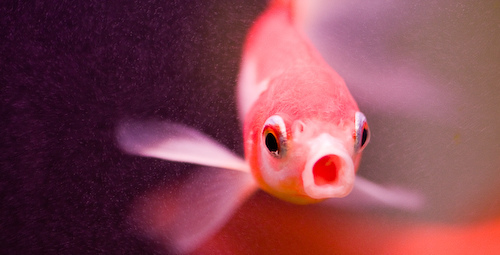

In [142]:
img=image.load(fileDir..'/'..fileList[5])
itorch.image(img)

In [188]:
--test = torch.load('./specific_object_statistic.t7')
goldfish = torch.load('./n01443537.t7')
--print(test[1].topN_index)
-- for i=1, 50 do
--     plot = Plot():line( point_index, test[i].insertion_curve,'red','Classification Curve'):legend(true):title('Insertion '..i):draw()
--     --plot = Plot():line( point_index, test[i].dropout_curve,'red','Classification Curve'):legend(true):title('Dropout '..i):draw() 
-- end